In [239]:
# pip install --upgrade spacy

In [240]:
# !python -m spacy download en_core_web_md

In [241]:
# pip install podium-nlp

In [242]:
# pip install hdbscan

In [243]:
# pip install bertopic

In [244]:
# pip install emoji

In [245]:
# pip install wordsegment

In [246]:
# pip install ekphrasis -U

In [247]:
# pip install k-means-constrained

In [248]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from bertopic import BERTopic
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe
from nltk.sentiment import SentimentIntensityAnalyzer
from copy import deepcopy
from nltk.tokenize.casual import TweetTokenizer
from time import time
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.segmenter import Segmenter
from k_means_constrained import KMeansConstrained
from gensim.models import CoherenceModel

import contextualSpellCheck
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji
import warnings
warnings.filterwarnings("ignore")

In [249]:
# from google.colab import drive
# drive.mount('/content/drive')

In [250]:
# %cd drive/MyDrive/datasets/

# Preprocessing

In [251]:
nlp = spacy.load("en_core_web_md")

In [252]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [253]:
df.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_test.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_replace.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)

## Getting clean text

In [254]:
tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)
df_tmp = df['Tweet text'].apply(tokenizer.tokenize)
df_test_tmp = df_test['Tweet text'].apply(tokenizer.tokenize)

In [255]:
def emoji_counter(s):
    return len(emoji.emoji_lis(s))

df['emoji_count'] = df['Tweet text'].apply(emoji_counter)
df_test['emoji_count'] = df_test['Tweet text'].apply(emoji_counter)

In [256]:
# seg_eng = Segmenter(corpus="english") 
seg_tw = Segmenter(corpus="twitter")

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [257]:
def separate_hashtags(s):
    '''Removes the hashtag sign and segments the hashtag text.'''
    hashtags = []
    
    l = []
    for i, s_i in enumerate(s):
        if s_i.startswith('#'):
            tmp = tokenizer.tokenize(seg_tw.segment(s_i.replace('#', '')))
            l.extend(tmp)
        else:
            l.append(s_i)
    return l
            
df_tmp = df_tmp.apply(separate_hashtags)
df_test_tmp = df_test_tmp.apply(separate_hashtags)

In [258]:
def preprocess_words(s):
    '''
    Removes tags, emojis, links, smiley faces, | signs, stopwords and changes the case to lower.
    '''
    ret_list = []

    smiley_regex = r'([\:\;\=][()PDO\/\]\[p|]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: emoji.is_emoji(w)
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)

    w2 = []
    for i, w in enumerate(s):
        if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
            continue

        elif is_hashtag(w):
            w_tmp = w.replace('#', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

        elif is_smiley(w):
            w_tmp = re.sub(smiley_regex, '', w)
            if w_tmp != '':
                lower_append(w_tmp, w2)

        else:
            w_tmp = w.replace('#', '')
            w_tmp = w_tmp.replace('|', '')
            w_tmp = w_tmp.replace('_', '')
            w_tmp = w_tmp.replace('...', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

    return ' '.join([i for i in w2 if len(i) > 2])

def lower_append(w, l):
    l.append(w.lower())

df['clean_text'] = df_tmp.apply(preprocess_words)
df_test['clean_text'] = df_test_tmp.apply(preprocess_words)

In [259]:
print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [260]:
print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [261]:
df_tmp2 = df['clean_text'].copy()

In [262]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

df['clean_text'] = df[['clean_text']].apply(remove_tuple_characters)
df_test['clean_text'] = df_test[['clean_text']].apply(remove_tuple_characters)

print(df.shape)
df.head(15)

(3817, 5)


,Tweet index,Label,Tweet text,emoji_count,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather
3,4,0,3 episodes left I'm dying over here,0,episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day


In [263]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [[w.lemma_.lower() for w in nlp(s_i) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct] for s_i in s]

df['lemmas'] = df[['clean_text']].apply(lemmatize)
df_test['lemmas'] = df_test[['clean_text']].apply(lemmatize)

In [264]:
print(df.shape)
df = df[df['lemmas'].apply(lambda x: len(x)) > 0]
print(df.shape)

(3817, 6)
(3795, 6)


In [265]:
df.head(15)

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...,"[sweet, united, nations, video, time, christma..."
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,..."
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather,"[hey, nice, minnesota, winter, weather]"
3,4,0,3 episodes left I'm dying over here,0,episodes left i'm dying over here,"[episode, leave, die]"
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual..."
5,6,0,You're never too old for Footie Pajamas. http:...,0,you're never too old for footie pajamas,"[old, footie, pajama]"
6,7,1,Nothing makes me happier then getting on the h...,0,nothing makes happier then getting the highway...,"[happy, highway, break, light, light, like, ch..."
7,8,0,4:30 an opening my first beer now gonna be a l...,0,4:30 opening first beer now gonna long night day,"[4:30, open, beer, long, night, day]"
8,9,0,@Adam_Klug do you think you would support a gu...,0,you think you would support guy who knocked ou...,"[think, support, guy, knock, daughter, rice, d..."
9,10,0,@samcguigan544 You are not allowed to open tha...,0,you are not allowed open that until christmas day,"[allow, open, christmas, day]"


In [266]:
### baseline features ###
tokenizer2 = TweetTokenizer()
def word_counter(s):
    return len([x for x in tokenizer.tokenize(s)])

def char_counter(s):
    return len(s.replace(' ', ''))

def all_uppercase_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.isupper() and not x.startswith(("@", "#", "http"))])

def all_lowercase_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.islower() and not x.startswith(("@", "#", "http"))])

def capitalised_counter(s):
    return sum([i.istitle() for i in tokenizer2.tokenize(s)])

def digit_counter(s):
    return sum([i.isdigit() for i in s])



### other features ###
def tag_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith("@")])

def hashtag_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith("#")])

def link_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if x.startswith(('http:', 'https:'))])

def smiley_counter(s):
    return len([x for x in tokenizer2.tokenize(s) if re.match(r'([\:\;\=][()PDO\/\]\[p|]+)+', x)])

def exclamation_mark_counter(s):
    return s.count('!')

def question_mark_counter(s):
    return s.count('?')

def ellipsis_counter(s):
    return s.count('...')
    


### NER ###
def ORG_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'ORG'])

def NORP_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'NORP'])

def GPE_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'GPE'])

def PERSON_tag_counter(s):
    doc = nlp(s)
    return len([d.text for d in doc.ents if d.label_ == 'PERSON'])

In [267]:
def add_features(some_df):
    some_df['word_count'] = some_df['clean_text'].apply(word_counter)
    some_df['char_count'] = some_df['clean_text'].apply(char_counter)
    some_df['all_uppercase_count'] = some_df['Tweet text'].apply(all_uppercase_counter)
    some_df['all_lowercase_count'] = some_df['Tweet text'].apply(all_lowercase_counter)
    some_df['capitalised_count'] = some_df['Tweet text'].apply(capitalised_counter)
    some_df['digit_count'] = some_df['Tweet text'].apply(digit_counter)
    
    some_df['tag_count'] = some_df['Tweet text'].apply(tag_counter)
    some_df['hashtag_count'] = some_df['Tweet text'].apply(hashtag_counter)
    some_df['link_count'] = some_df['Tweet text'].apply(link_counter)
    some_df['smiley_count'] = some_df['Tweet text'].apply(smiley_counter)
    
    some_df['exclamation_mark_count'] = some_df['Tweet text'].apply(exclamation_mark_counter)
    some_df['question_mark_count'] = some_df['Tweet text'].apply(question_mark_counter)
    some_df['ellipsis_count'] = some_df['Tweet text'].apply(ellipsis_counter)
    
    some_df['ORG_tag_count'] = some_df['Tweet text'].apply(ORG_tag_counter)
    some_df['NORP_tag_count'] = some_df['Tweet text'].apply(NORP_tag_counter)
    some_df['GPE_tag_count'] = some_df['Tweet text'].apply(GPE_tag_counter)
    some_df['PERSON_tag_count'] = some_df['Tweet text'].apply(PERSON_tag_counter)
    
add_features(df)
add_features(df_test)

In [268]:
df.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,hashtag_count,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count
0,1,1,Sweet United Nations video. Just in time for C...,0,sweet united nations video just time for chris...,"[sweet, united, nations, video, time, christma...",10,58,0,4,...,2,1,0,0,0,0,1,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,0,are rumored have talked erv's agent and the an...,"[rumor, talk, erv, agent, angel, ask, escobar,...",15,78,0,14,...,0,0,1,0,0,2,0,0,0,2
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,0,hey there nice see you minnesota winter weather,"[hey, nice, minnesota, winter, weather]",8,40,1,4,...,0,0,0,1,0,0,0,0,1,0
3,4,0,3 episodes left I'm dying over here,0,episodes left i'm dying over here,"[episode, leave, die]",6,28,0,5,...,0,0,0,0,0,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,0,can't breathe was chosen the most notable quot...,"[breathe, choose, notable, quote, year, annual...",16,88,1,20,...,0,0,0,1,0,0,1,0,0,0


In [269]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [270]:
df_train.reset_index(inplace=True, drop=True)
df_validation.reset_index(inplace=True, drop=True)

In [271]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,hashtag_count,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count
0,795,0,Casper the friendly ghost on 2 levels! #things...,0,casper the friendly ghost levels things michel...,"[casper, friendly, ghost, level, thing, michel...",11,62,0,5,...,1,0,0,1,0,0,0,0,1,0
1,2409,0,@rj4gui4r you wearing the pin I sent for the r...,0,you wearing the pin sent for the rest the vide...,"[wear, pin, send, rest, video, yesterday, day,...",16,69,1,15,...,2,1,0,0,0,0,0,0,0,0
2,1048,0,Cats are so cute I wish I wasn't allergic 😭😭,2,cats are cute wish wasn't allergic,"[cat, cute, wish, allergic]",6,29,2,6,...,0,0,0,0,0,0,0,0,0,0
3,1719,1,Woke up to find out my vehicle insurance went ...,1,woke find out vehicle insurance went month mer...,"[wake, find, vehicle, insurance, month, merry,...",9,50,0,13,...,0,0,0,2,0,1,0,0,0,0
4,1930,1,Love waking up to grumpy people,0,love waking grumpy people,"[love, wake, grumpy, people]",4,22,0,5,...,0,0,0,0,0,0,0,0,0,0


In [272]:
def new_df_with_all_features(df1, df2):
    cols_to_add = list(set(df2.columns.tolist()) - set(df1.columns.tolist()))
    if 'Tweet index' in cols_to_add:
        cols_to_add.remove('Tweet index')
    new_df = pd.concat((df1.copy(), df2[cols_to_add]), axis=1)
    return new_df

In [273]:
def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return ' '.join(s)

df_train['topic_text'] = df_train['lemmas'].apply(join_docs)
df_validation['topic_text'] = df_validation['lemmas'].apply(join_docs)
df_test['topic_text'] = df_test['lemmas'].apply(join_docs)

In [274]:
df_train.shape

(2656, 24)

In [275]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,link_count,smiley_count,exclamation_mark_count,question_mark_count,ellipsis_count,ORG_tag_count,NORP_tag_count,GPE_tag_count,PERSON_tag_count,topic_text
0,795,0,Casper the friendly ghost on 2 levels! #things...,0,casper the friendly ghost levels things michel...,"[casper, friendly, ghost, level, thing, michel...",11,62,0,5,...,0,0,1,0,0,0,0,1,0,casper friendly ghost level thing michelle oba...
1,2409,0,@rj4gui4r you wearing the pin I sent for the r...,0,you wearing the pin sent for the rest the vide...,"[wear, pin, send, rest, video, yesterday, day,...",16,69,1,15,...,1,0,0,0,0,0,0,0,0,wear pin send rest video yesterday day day add...
2,1048,0,Cats are so cute I wish I wasn't allergic 😭😭,2,cats are cute wish wasn't allergic,"[cat, cute, wish, allergic]",6,29,2,6,...,0,0,0,0,0,0,0,0,0,cat cute wish allergic
3,1719,1,Woke up to find out my vehicle insurance went ...,1,woke find out vehicle insurance went month mer...,"[wake, find, vehicle, insurance, month, merry,...",9,50,0,13,...,0,0,2,0,1,0,0,0,0,wake find vehicle insurance month merry christmas
4,1930,1,Love waking up to grumpy people,0,love waking grumpy people,"[love, wake, grumpy, people]",4,22,0,5,...,0,0,0,0,0,0,0,0,0,love wake grumpy people


## Topic modeling baselines

In [276]:
count_vectorizer = CountVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tweet_text_count_train = count_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_count_validation = count_vectorizer.transform(df_validation['topic_text'])
tweet_text_count_test = count_vectorizer.transform(df_test['topic_text'])

tweet_text_tfidf_train = tfidf_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_tfidf_validation = tfidf_vectorizer.transform(df_validation['topic_text'])
tweet_text_tfidf_test = tfidf_vectorizer.transform(df_test['topic_text'])

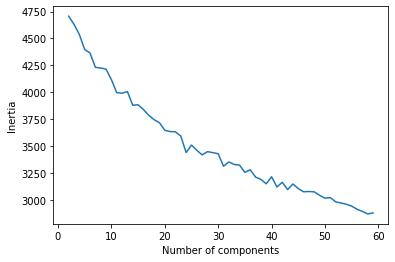

In [277]:
inertia = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [278]:
from gensim import corpora

texts = [l for l in df_train['lemmas']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

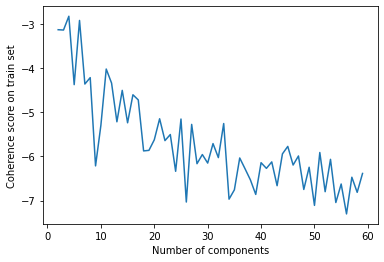

In [279]:
def calc_coherence(model, y_train, y_val, length=4):
    # count words and create a dictionary of occurences
    occurences = {i:0 for i in range(0, max(y_train)+1)}
    for i in occurences.keys():
        occurences[i] = (y_train == i).sum()
    sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

    # find most often used words
    keys_max_count_all = []
    for k in sorted_occ_keys:
        indices = np.where(y_train == k)[0]
        l_words = []
        for l in df_train['lemmas'][indices].values.tolist():
            l_words.extend(l)
        d = {i: l_words.count(i) for i in set(l_words)}
        keys_max_count = sorted(d, key=d.get, reverse=True)[:length]
        keys_max_count_all.append(keys_max_count)
        
    # coherence calculation
    cm = CoherenceModel(topics=keys_max_count_all, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence = cm.get_coherence()
    return coherence

coherences = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    
    kmeans_count_labels_train = model.predict(tweet_text_count_train)
    kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
    kmeans_count_labels_test = model.predict(tweet_text_count_test)

    coh = calc_coherence(model, kmeans_count_labels_train, kmeans_count_labels_validation)
    coherences.append(coh)
    
plt.plot(range_, coherences)
plt.xlabel('Number of components')
plt.ylabel('Coherence score on train set')
plt.show()

In [280]:
print(f'Coherence max: {[(i+2, c) for i, c in enumerate(coherences) if c == max(coherences)]}')

Coherence max: [(4, -2.8304392776468106)]


In [281]:
model = KMeans(5)
model.fit(tweet_text_count_train)

kmeans_count_labels_train = model.predict(tweet_text_count_train)
kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
kmeans_count_labels_test = model.predict(tweet_text_count_test)

In [282]:
occurences = {i:0 for i in range(max(kmeans_count_labels_train))}
for i in occurences.keys():
    occurences[i] = (kmeans_count_labels_train == i).sum()
    
sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

for i in range(3):
    indices = np.where(kmeans_count_labels_train == i)[0]
    indices_random = np.random.randint(0, len(indices), size=3)
    [print(df_train['Tweet text'][i]) for i in indices_random.tolist()]
    print()

I love how when I'm stressed my body decides to react by causing me massive pain. 
Hey what do you know, one of the witnesses supporting Darren Wilson's story lied! And is racist! Mind blown! http://t.co/0k25FE024w 
@SincerelyTumblr: One day I want to travel with my bestfriend 🌏✈️ http://t.co/AXD3Ax5qC1 DONE DID TRAVELED DA WORLD!! @Bethanycsmithh ❤️

love being able to be comfortable in my own room😃👍 
#New#color#new#beginning#new#goals#dont#giveup#never#life#should#be#easy @ skdar http://t.co/bzmXE0K98i
Produce all kinds of Creative Designs #like15| http://t.co/OXeuznMhY8 http://t.co/w4eZ9mObFJ

@oneplanetmikey @misskylie77 I had never heard of them before, but I quite liked it!
Love coming to school knowing I have tests all day 
you is very much right my brother when I am done I still will not have a car, and when I am done praising Allah I to will still  (1/2)



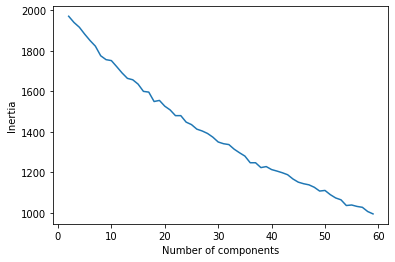

In [283]:
inertia = []
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

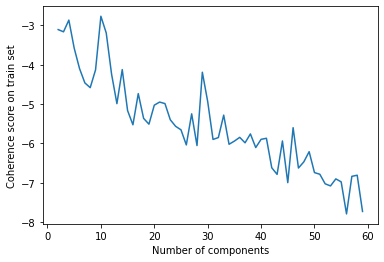

In [284]:
coherences = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    
    kmeans_tfidf_labels_train = model.predict(tweet_text_tfidf_train)
    kmeans_tfidf_labels_validation = model.predict(tweet_text_tfidf_validation)
    kmeans_tfidf_labels_test = model.predict(tweet_text_tfidf_test)

    coh = calc_coherence(model, kmeans_tfidf_labels_train, kmeans_tfidf_labels_validation)
    coherences.append(coh)
    
plt.plot(range_, coherences)
plt.xlabel('Number of components')
plt.ylabel('Coherence score on train set')
plt.show()

In [285]:
print(f'Coherence max: {[(i+2, c) for i, c in enumerate(coherences) if c == max(coherences)]}')

Coherence max: [(10, -2.7687881829278473)]


In [286]:
model = KMeans(15)
model.fit(tweet_text_tfidf_train)

kmeans_tfidf_labels_train = model.predict(tweet_text_tfidf_train)
kmeans_tfidf_labels_validation = model.predict(tweet_text_tfidf_validation)
kmeans_tfidf_labels_test = model.predict(tweet_text_tfidf_test)

In [287]:
occurences = {i:0 for i in range(max(kmeans_tfidf_labels_train))}
for i in occurences.keys():
    occurences[i] = (kmeans_tfidf_labels_train == i).sum()
    
sorted_occ_keys = sorted(occurences, key=occurences.get, reverse=True)

for i in range(3):
    indices = np.where(kmeans_tfidf_labels_train == i)[0]
    indices_random = np.random.randint(0, len(indices), size=3)
    [print(df_train['Tweet text'][i]) for i in indices_random.tolist()]
    print()

Ay after 2 hours nareceive ko rin yung message haha thanks globe 
.@7eleven Big Gulps for health care http://t.co/CNuAviEMPY 
@Luxtonr7 @adamjamesberack LFC worst start in 50 years and still above EFC.... that is funny!!! #WishWeHadA28MilStriker 

OMG! #Berlin is so fashion!  #vscocam http://t.co/J6qrlxv82z
Can't wait to see that he has not talked to me and that he will never do it. 
Saturday selfies miss you guys @ellakcx @taracasey13 jessica101xxx mark8 😘😘😘😘kiss each and one... http://t.co/9tG4rKuYNj

@UKLabour ||How dare @David_Cameron not pass legislation to force people to catch buses on those routes. Should be a life in jail.||
Hold It Bub! >> http://t.co/M4UO2D7UuF >> #cartoon #comics #funny #jesus 
Quel domage  RT @CFL_News: No Canada: Bills in TO series, which was a colossal flop, has been cancelled http://t.co/LBIF1WE2pW #CFL #NFL



### BERTopic

In [288]:
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [405]:
docs = df_validation['topic_text'].values.tolist()

def calc_coherence(topic_model, topics):
    # Preprocess Documents
    documents = pd.DataFrame({
        "Document": docs,
        "ID": range(len(docs)),
        "Topic": topics}
    )
    
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    
    # Preprocess Documents
    cleaned_docs = topic_model._preprocess_text(docs)

    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [
        [words for words, _ in topic_model.get_topic(topic) if words != ''] 
    for topic in range(len(set(topics))-1)]
    
    # Evaluate
    cm = CoherenceModel(
        topics=topic_words, 
        texts=tokens, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence='u_mass'
    )
    return cm.get_coherence()

In [406]:
tmp = {}
start = time()
for i in range(5, 11, 1):
    for j in range(10, 61, 10):
        topic_model = BERTopic(top_n_words=i, min_topic_size=j)
        topic_model.fit(df_train['topic_text'])
        topics, probs = topic_model.transform(df_validation['topic_text'])
        c = calc_coherence(topic_model, topics)
        tmp[(i, j)] = c
    print(f'finished for {i}')
end = time()
print(f'{end-start}s')

finished for 5
finished for 6
finished for 7
finished for 8
finished for 9
finished for 10
50.95404648780823s


In [412]:
tmp

{(5, 10): nan,
 (5, 20): -17.242793086272712,
 (5, 30): -16.628126361823277,
 (5, 40): -16.34264203731877,
 (5, 50): -18.674374299348923,
 (5, 60): -17.62443116586082,
 (6, 10): nan,
 (6, 20): -17.627188468235293,
 (6, 30): -17.465175784019166,
 (6, 40): -17.41325563468783,
 (6, 50): -17.361034729475435,
 (6, 60): -18.362496182882126,
 (7, 10): -19.010653832842415,
 (7, 20): -17.245800389232173,
 (7, 30): -17.6667434716104,
 (7, 40): -16.947987833962358,
 (7, 50): -18.25165381413589,
 (7, 60): -17.806879123837398,
 (8, 10): -19.22744559924982,
 (8, 20): -18.27859773546997,
 (8, 30): -17.88261427844002,
 (8, 40): -17.411541647895948,
 (8, 50): -17.577662419233892,
 (8, 60): -17.962555046897553,
 (9, 10): -19.409568141497807,
 (9, 20): -17.96347397618078,
 (9, 30): -17.72684870070877,
 (9, 40): -18.259710425786377,
 (9, 50): -17.65862920503491,
 (9, 60): -17.432911827623396,
 (10, 10): -19.288637305173104,
 (10, 20): -18.11941683649315,
 (10, 30): -18.366053611395873,
 (10, 40): -17.6935

In [413]:
start = time()
topic_model = BERTopic(top_n_words=10, min_topic_size=20)
topics, probs = topic_model.fit_transform(df_train['topic_text'])

pred_train = topic_model.transform(df_train['topic_text'])
pred_validation = topic_model.transform(df_validation['topic_text'])
pred_test = topic_model.transform(df_test['topic_text'])
end = time()
print(f'{end-start}s')

51.249374866485596s


In [292]:
# probability_threshold = 0.07
# new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_train[1]]
# np.unique(new_topics, return_counts=True)

In [293]:
# probability_threshold = 0.07
# new_topics_train = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_train[1]]
# new_topics_validation = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_validation[1]]
# new_topics_test = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in pred_test[1]]
# np.unique(new_topics_train, return_counts=True)

In [414]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1403,-1_day_like_work_love
1,0,219,0_black_police_ferguson_right
2,1,202,1_love_girl_life_look
3,2,119,2_team_game_player_win
4,3,106,3_service_money_app_xbox
5,4,101,4_funny_lol_know_laugh
6,5,99,5_sleep_wake_morning_bed
7,6,93,6_christmas_gift_merry_santa
8,7,83,7_twitter_tweet_people_social
9,8,79,8_school_study_teacher_math


In [295]:
# df_train_bertopic = df_train.copy()
# df_validation_bertopic = df_validation.copy()
# df_test_bertopic = df_test.copy()

In [296]:
df_train['topic'] = pred_train[0]
df_validation['topic'] = pred_validation[0]
df_test['topic'] = pred_test[0]

In [369]:
type(topic_model.vectorizer_model)

sklearn.feature_extraction.text.CountVectorizer

In [297]:
# df_train_bertopic.head()

## Embedding

In [298]:
tweet_embedding_train = df_train[['topic_text', 'Label']]
tweet_embedding_validation = df_validation[['topic_text', 'Label']]
tweet_embedding_test = df_test[['topic_text', 'Label']]

In [299]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)
tweet_embedding_test.reset_index(drop=True, inplace=True)

In [300]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=20)

TWEET = Field('text', numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(df_train[['topic_text', 'Label']], fields)
validation = TabularDataset.from_pandas(df_validation[['topic_text', 'Label']], fields)
test = TabularDataset.from_pandas(df_test[['topic_text', 'Label']], fields)
train.finalize_fields()

glove = GloVe()
embeddings = glove.load_vocab(vocab)

train_batch = train.batch(add_padding=True)
validation_batch = validation.batch(add_padding=True)
test_batch = test.batch(add_padding=True)

In [301]:
train_batch['text'].astype(int)[0:5]

array([[ 0,  0,  0,  0, 11,  0,  0, 12,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  3,  3,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [52, 42,  0,  0,  0,  0, 17,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1],
       [ 2, 52,  0,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1]])

In [302]:
tweet_train = embeddings[train_batch['text'].astype(int)]
tweet_validation = embeddings[validation_batch['text'].astype(int)]
tweet_test = embeddings[test_batch['text'].astype(int)]

# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_validation_mean = tweet_validation.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)

In [303]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
df_train = pd.merge(df_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_validation_mean_df = pd.DataFrame(tweet_validation_mean)
df_validation = pd.merge(df_validation, embeddings_validation_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
df_test = pd.merge(df_test, embeddings_test_mean_df, left_index=True, right_index=True)

In [304]:
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,290,291,292,293,294,295,296,297,298,299
0,795,0,Casper the friendly ghost on 2 levels! #things...,0,casper the friendly ghost levels things michel...,"[casper, friendly, ghost, level, thing, michel...",11,62,0,5,...,1.087114,-0.003236,0.315247,1.372088,-0.524101,-0.731357,0.038075,0.143135,0.367418,-0.008434
1,2409,0,@rj4gui4r you wearing the pin I sent for the r...,0,you wearing the pin sent for the rest the vide...,"[wear, pin, send, rest, video, yesterday, day,...",16,69,1,15,...,1.059188,0.001305,0.274774,1.362820,-0.540109,-0.641725,0.043914,0.105879,0.306694,-0.048774
2,1048,0,Cats are so cute I wish I wasn't allergic 😭😭,2,cats are cute wish wasn't allergic,"[cat, cute, wish, allergic]",6,29,2,6,...,1.060909,-0.046952,0.538278,1.672441,-0.450968,-0.851887,-0.090451,-0.021229,0.324054,0.080765
3,1719,1,Woke up to find out my vehicle insurance went ...,1,woke find out vehicle insurance went month mer...,"[wake, find, vehicle, insurance, month, merry,...",9,50,0,13,...,0.912475,-0.072538,0.420612,1.408258,-0.421082,-0.719088,-0.032963,0.021481,0.271149,0.041386
4,1930,1,Love waking up to grumpy people,0,love waking grumpy people,"[love, wake, grumpy, people]",4,22,0,5,...,0.797917,-0.156375,0.560637,1.473449,-0.247425,-0.781748,-0.152986,-0.127464,0.209326,0.161010


In [305]:
nltk.download('vader_lexicon') # if error run this

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [306]:
def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['topic_text']) > 0:
            doc = nlp(row['topic_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(deepcopy(current_neg))
            neg_word_count.append(deepcopy(len(current_neg)))
            pos_words.append(deepcopy(current_pos))
            pos_word_count.append(deepcopy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [307]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)
neg_words_test, neg_word_count_test, pos_words_test, pos_word_count_test = pos_neg_words(df_test, 0.2)

In [308]:
df_train['neg_word_count'] = neg_word_count_train
df_train['pos_word'] = pos_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['neg_word'] = neg_words_train

df_validation['neg_word_count'] = neg_word_count_val
df_validation['pos_word'] = pos_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['neg_word'] = neg_words_val

df_test['neg_word_count'] = neg_word_count_test
df_test['pos_word'] = pos_words_test
df_test['pos_word_count'] = pos_word_count_test
df_test['neg_word'] = neg_words_test

df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,294,295,296,297,298,299,neg_word_count,pos_word,pos_word_count,neg_word
0,795,0,Casper the friendly ghost on 2 levels! #things...,0,casper the friendly ghost levels things michel...,"[casper, friendly, ghost, level, thing, michel...",11,62,0,5,...,-0.524101,-0.731357,0.038075,0.143135,0.367418,-0.008434,2,[friendly],1,"[ghost, racist]"
1,2409,0,@rj4gui4r you wearing the pin I sent for the r...,0,you wearing the pin sent for the rest the vide...,"[wear, pin, send, rest, video, yesterday, day,...",16,69,1,15,...,-0.540109,-0.641725,0.043914,0.105879,0.306694,-0.048774,0,[],0,[]
2,1048,0,Cats are so cute I wish I wasn't allergic 😭😭,2,cats are cute wish wasn't allergic,"[cat, cute, wish, allergic]",6,29,2,6,...,-0.450968,-0.851887,-0.090451,-0.021229,0.324054,0.080765,1,"[cute, wish]",2,[allergic]
3,1719,1,Woke up to find out my vehicle insurance went ...,1,woke find out vehicle insurance went month mer...,"[wake, find, vehicle, insurance, month, merry,...",9,50,0,13,...,-0.421082,-0.719088,-0.032963,0.021481,0.271149,0.041386,0,[merry],1,[]
4,1930,1,Love waking up to grumpy people,0,love waking grumpy people,"[love, wake, grumpy, people]",4,22,0,5,...,-0.247425,-0.781748,-0.152986,-0.127464,0.209326,0.161010,0,[love],1,[]


In [309]:
topic_dummies = []
for i in topic_model.get_topic_info()['Topic'].values:
    topic_dummies.append(f'{i}_topic')
    
topic_dummies

['-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic',
 '13_topic',
 '14_topic',
 '15_topic',
 '16_topic',
 '17_topic']

In [310]:
df_train[topic_dummies] = pd.get_dummies(df_train['topic'])
df_validation[topic_dummies] = pd.get_dummies(df_validation['topic'])
df_test[topic_dummies] = pd.get_dummies(df_test['topic'])
df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,8_topic,9_topic,10_topic,11_topic,12_topic,13_topic,14_topic,15_topic,16_topic,17_topic
0,795,0,Casper the friendly ghost on 2 levels! #things...,0,casper the friendly ghost levels things michel...,"[casper, friendly, ghost, level, thing, michel...",11,62,0,5,...,0,0,1,0,0,0,0,0,0,0
1,2409,0,@rj4gui4r you wearing the pin I sent for the r...,0,you wearing the pin sent for the rest the vide...,"[wear, pin, send, rest, video, yesterday, day,...",16,69,1,15,...,0,0,0,0,0,0,0,0,0,0
2,1048,0,Cats are so cute I wish I wasn't allergic 😭😭,2,cats are cute wish wasn't allergic,"[cat, cute, wish, allergic]",6,29,2,6,...,0,0,0,0,0,0,0,0,0,0
3,1719,1,Woke up to find out my vehicle insurance went ...,1,woke find out vehicle insurance went month mer...,"[wake, find, vehicle, insurance, month, merry,...",9,50,0,13,...,0,0,0,0,0,0,0,0,0,0
4,1930,1,Love waking up to grumpy people,0,love waking grumpy people,"[love, wake, grumpy, people]",4,22,0,5,...,0,0,0,0,0,0,0,0,0,0


In [311]:
# X_ = df_train[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_ = df_train['Label']
# clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_, y_)

# print('Train score')
# print(clf.score(X_, y_))

# X_val = df_validation[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_val = df_validation['Label']

# print('Validation score')
# print(clf.score(X_val, y_val))

# X_val = df_test[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
#                '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
# y_val = df_test['Label']
# print('Test score')
# print(clf.score(X_val, y_val))

In [312]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        think burgerking working with the sjws fries a...
pos_word                                               [win, award]
pos_word_count                                                    2
neg_word                                                         []
neg_word_count                                                    0
Name: 25, dtype: object

In [313]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(deepcopy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [314]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)
within_5_test = pos_neg_within_n(df_test, n=5)

In [315]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val
df_test['pos_neg_within_5'] = within_5_test

df_train.head()

,Tweet index,Label,Tweet text,emoji_count,clean_text,lemmas,word_count,char_count,all_uppercase_count,all_lowercase_count,...,9_topic,10_topic,11_topic,12_topic,13_topic,14_topic,15_topic,16_topic,17_topic,pos_neg_within_5
0,795,0,Casper the friendly ghost on 2 levels! #things...,0,casper the friendly ghost levels things michel...,"[casper, friendly, ghost, level, thing, michel...",11,62,0,5,...,0,1,0,0,0,0,0,0,0,1
1,2409,0,@rj4gui4r you wearing the pin I sent for the r...,0,you wearing the pin sent for the rest the vide...,"[wear, pin, send, rest, video, yesterday, day,...",16,69,1,15,...,0,0,0,0,0,0,0,0,0,0
2,1048,0,Cats are so cute I wish I wasn't allergic 😭😭,2,cats are cute wish wasn't allergic,"[cat, cute, wish, allergic]",6,29,2,6,...,0,0,0,0,0,0,0,0,0,1
3,1719,1,Woke up to find out my vehicle insurance went ...,1,woke find out vehicle insurance went month mer...,"[wake, find, vehicle, insurance, month, merry,...",9,50,0,13,...,0,0,0,0,0,0,0,0,0,0
4,1930,1,Love waking up to grumpy people,0,love waking grumpy people,"[love, wake, grumpy, people]",4,22,0,5,...,0,0,0,0,0,0,0,0,0,0


In [316]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']

clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))

X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']

print('Validation score')
print(clf.score(X_val, y_val))

Train score
0.5131777108433735
Validation score
0.5215100965759438


## Baseline classifiers

In [317]:
baseline_features = ['word_count', 'char_count', 'all_uppercase_count', 'all_lowercase_count', 'capitalised_count', 'digit_count']

y_train = df_train['Label']
x_train = df_train[baseline_features]

y_validation = df_validation['Label']
x_validation = df_validation[baseline_features]

y_test = df_test['Label']
x_test = df_test[baseline_features]

In [318]:
x_train.head()

,word_count,char_count,all_uppercase_count,all_lowercase_count,capitalised_count,digit_count
0,11,62,0,5,1,1
1,16,69,1,15,1,2
2,6,29,2,6,3,0
3,9,50,0,13,3,2
4,4,22,0,5,1,0


In [319]:
def model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    print('-------------------------- TRAIN --------------------------')
    print(classification_report(y_train, y_train_pred, digits=3), 2*'\n')
    
    y_validation_pred = model.predict(x_validation)
    print('----------------------- VALIDATION ------------------------')
    print(classification_report(y_validation, y_validation_pred, digits=3), 2*'\n')
    
    y_test_pred = model.predict(x_test)
    print('------------------------- TEST ---------------------------')
    print(classification_report(y_test, y_test_pred, digits=3), 2*'\n')

## Global baseline classifier

In [320]:
model = LogisticRegression()
model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.634     0.463     0.535      1315
           1      0.583     0.738     0.652      1341

    accuracy                          0.602      2656
   macro avg      0.609     0.600     0.593      2656
weighted avg      0.608     0.602     0.594      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.627     0.429     0.510       585
           1      0.548     0.731     0.626       554

    accuracy                          0.576      1139
   macro avg      0.588     0.580     0.568      1139
weighted avg      0.589     0.576     0.566      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.727     0.478     0.577       473
           1      0.478     0.727     0.577       31

## Global best classifier

In [323]:
to_drop = ['Label', 'Tweet text', 'Tweet index', 'clean_text', 'lemmas', 'pos_word', 'neg_word', 'topic', 'topic_text']

x_train = df_train.drop(columns=to_drop)
x_validation = df_validation.drop(columns=to_drop)
x_test = df_test.drop(columns=to_drop)

In [372]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

KeyboardInterrupt: 

In [325]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.689     0.659     0.674      1315
           1      0.680     0.708     0.694      1341

    accuracy                          0.684      2656
   macro avg      0.684     0.684     0.684      2656
weighted avg      0.684     0.684     0.684      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.585     0.856     0.695       585
           1      0.702     0.357     0.474       554

    accuracy                          0.614      1139
   macro avg      0.643     0.607     0.584      1139
weighted avg      0.642     0.614     0.587      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.733     0.655     0.692       473
           1      0.548     0.637     0.589       31

In [326]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6475850643558048
Best score: {'lr__C': 0.9326033468832199, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [327]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.688     0.668     0.678      1315
           1      0.684     0.703     0.693      1341

    accuracy                          0.686      2656
   macro avg      0.686     0.686     0.686      2656
weighted avg      0.686     0.686     0.686      2656
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.586     0.870     0.701       585
           1      0.720     0.352     0.473       554

    accuracy                          0.618      1139
   macro avg      0.653     0.611     0.587      1139
weighted avg      0.651     0.618     0.590      1139
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.729     0.638     0.681       473
           1      0.538     0.640     0.584       31

In [419]:
x_train.columns.tolist()[-22:]

['neg_word_count',
 'pos_word_count',
 '-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic',
 '13_topic',
 '14_topic',
 '15_topic',
 '16_topic',
 '17_topic',
 'pos_neg_within_5']

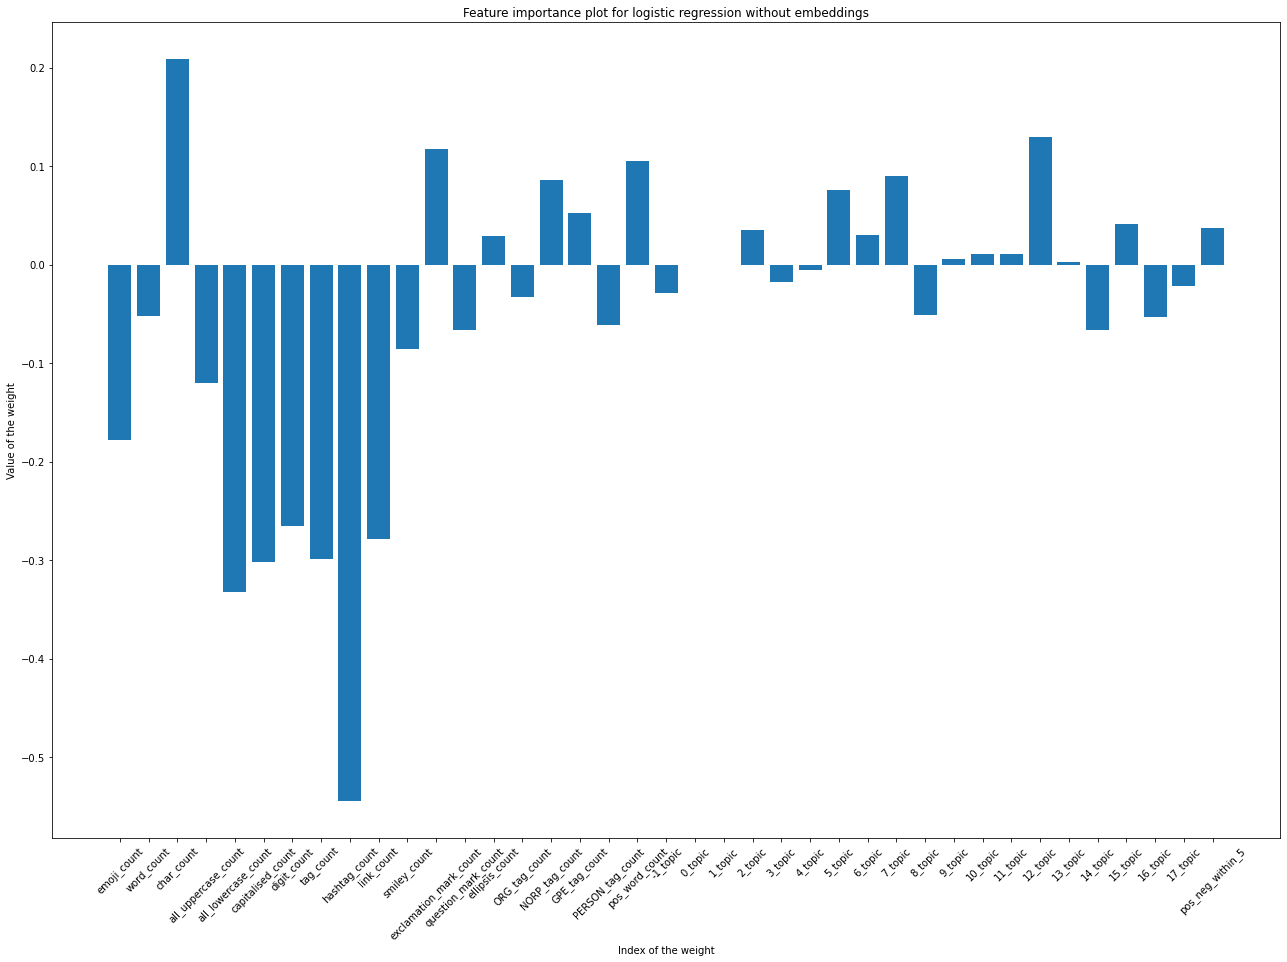

In [424]:
weights = pipeline_lr_best['lr'].coef_.flatten()
weights_wo_embeddings = weights[:18].tolist()
weights_wo_embeddings.extend(weights[-21:])

weights_embeddings = weights[18:318].tolist()

features = x_train.columns.tolist()[:18]
features.extend(x_train.columns.tolist()[-21:])

plt.figure(figsize=(22, 15))
plt.bar(features, weights_wo_embeddings)
plt.ylabel('Value of the weight')
plt.xlabel('Index of the weight')
plt.xticks(rotation = 45) 
plt.title('Feature importance plot for logistic regression without embeddings')
plt.show()

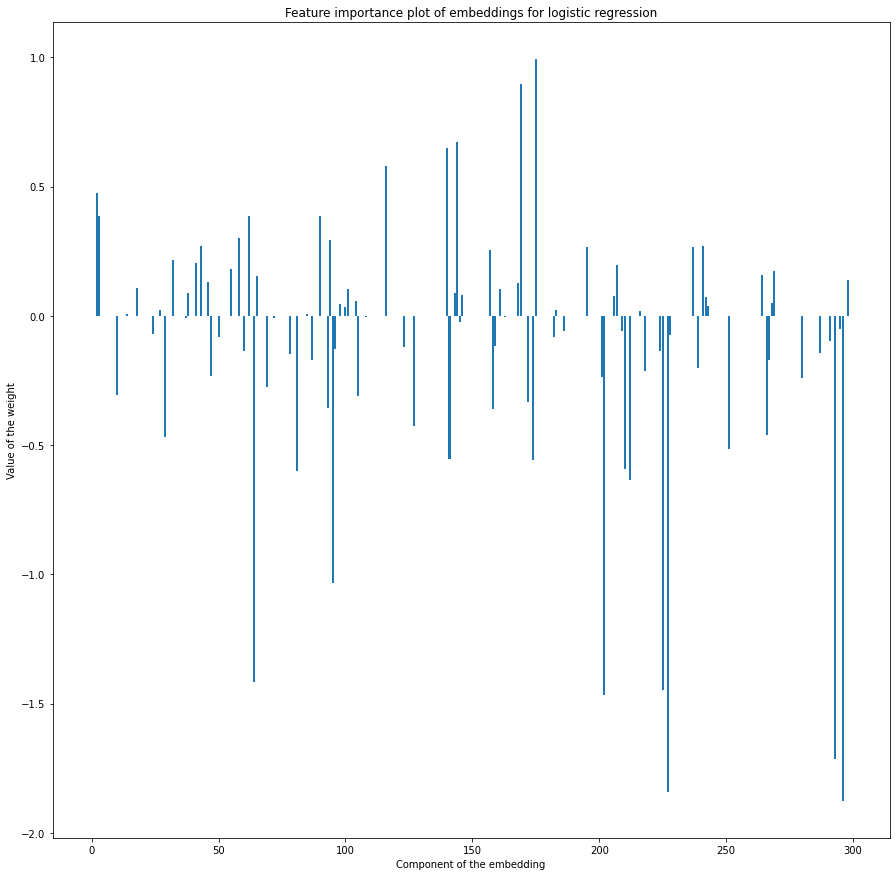

In [416]:
plt.figure(figsize=(15, 15))
plt.bar(list(range(len(weights_embeddings))), weights_embeddings)
plt.ylabel('Value of the weight')
plt.xlabel('Component of the embedding')
plt.title('Feature importance plot of embeddings for logistic regression')
plt.show()

In [ ]:
# pipeline_dtc = Pipeline([
#     ('dtc', DecisionTreeClassifier()),
# ])

# # mozda potrebno pojacat grid, nisam vrtio
# params = {
#     'dtc__max_features': ['auto', 'sqrt', 'log2'],
#     'dtc__ccp_alpha': [0.1, .01, .001],
#     'dtc__max_depth' : list(range(2, 10)),
#     'dtc__criterion' : ['gini', 'entropy', 'log_loss']
# }
# search = GridSearchCV(pipeline_dtc, param_grid=params, cv=5)
# search.fit(x_train, y_train)

# print(f'Best score: {search.best_score_}')
# print(f'Best score: {search.best_params_}')

In [ ]:
# bp = search.best_params_
# pipeline_dtc_best = Pipeline([
#     ('dtc', DecisionTreeClassifier(
#         ccp_alpha=bp['dtc__ccp_alpha'], 
#         criterion=bp['dtc__criterion'], 
#         max_depth=bp['dtc__max_depth'], 
#         max_features=bp['dtc__max_features'])
#     ),
# ])

# model_fit_evaluate(pipeline_dtc_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

In [ ]:
# feat_importances = pipeline_dtc_best['dtc'].feature_importances_.flatten()

# plt.figure(figsize=(5, 5))
# plt.bar(list(range(len(feat_importances))), feat_importances)
# plt.ylabel('Feature importance value')
# plt.xlabel('Index of the feature')
# plt.title('Feature importance plot for decision tree')
# plt.show()

In [474]:
x_train.columns.tolist()

['emoji_count',
 'word_count',
 'char_count',
 'all_uppercase_count',
 'all_lowercase_count',
 'capitalised_count',
 'digit_count',
 'tag_count',
 'hashtag_count',
 'link_count',
 'smiley_count',
 'exclamation_mark_count',
 'question_mark_count',
 'ellipsis_count',
 'ORG_tag_count',
 'NORP_tag_count',
 'GPE_tag_count',
 'PERSON_tag_count',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,


## Baseline classifiers for the first 4 topics

In [450]:
def get_train_validation_and_test_for_topic(topic_num, df_train, df_validation, df_test, features=baseline_features):
    df_train_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_validation_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_test_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    
    y_train = df_train_topic['Label']
    x_train = df_train_topic[features]

    y_validation = df_validation_topic['Label']
    x_validation = df_validation_topic[features]

    y_test = df_test_topic['Label']
    x_test = df_test_topic[features]
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [478]:
features_for_spec_topic = x_train.columns.tolist()[:18]
sentiment_features = x_train.columns.tolist()[-1:]
sentiment_features.extend(x_train.columns.tolist()[318:320])
sentiment_features.extend(features_for_spec_topic)
sentiment_features.extend(x_train.columns.tolist()[18:318])
features_for_spec_topic = sentiment_features

print(features_for_spec_topic)

['pos_neg_within_5', 'neg_word_count', 'pos_word_count', 'emoji_count', 'word_count', 'char_count', 'all_uppercase_count', 'all_lowercase_count', 'capitalised_count', 'digit_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'exclamation_mark_count', 'question_mark_count', 'ellipsis_count', 'ORG_tag_count', 'NORP_tag_count', 'GPE_tag_count', 'PERSON_tag_count', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,

## Best classifier and baseline for the 1st topic

In [455]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.657     0.549     0.598       618
           1      0.591     0.695     0.639       580

    accuracy                          0.619      1198
   macro avg      0.624     0.622     0.618      1198
weighted avg      0.625     0.619     0.618      1198
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.657     0.549     0.598       618
           1      0.591     0.695     0.639       580

    accuracy                          0.619      1198
   macro avg      0.624     0.622     0.618      1198
weighted avg      0.625     0.619     0.618      1198
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.657     0.549     0.598       618
           1      0.591     0.695     0.639       58

In [464]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 2),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train_, y_train_)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6443619246861925
Best score: {'lr__C': 1000.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [490]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.735     0.744     0.740       618
           1      0.724     0.714     0.719       580

    accuracy                          0.730      1198
   macro avg      0.729     0.729     0.729      1198
weighted avg      0.729     0.730     0.729      1198
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.735     0.744     0.740       618
           1      0.724     0.714     0.719       580

    accuracy                          0.730      1198
   macro avg      0.729     0.729     0.729      1198
weighted avg      0.729     0.730     0.729      1198
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.735     0.744     0.740       618
           1      0.724     0.714     0.719       58

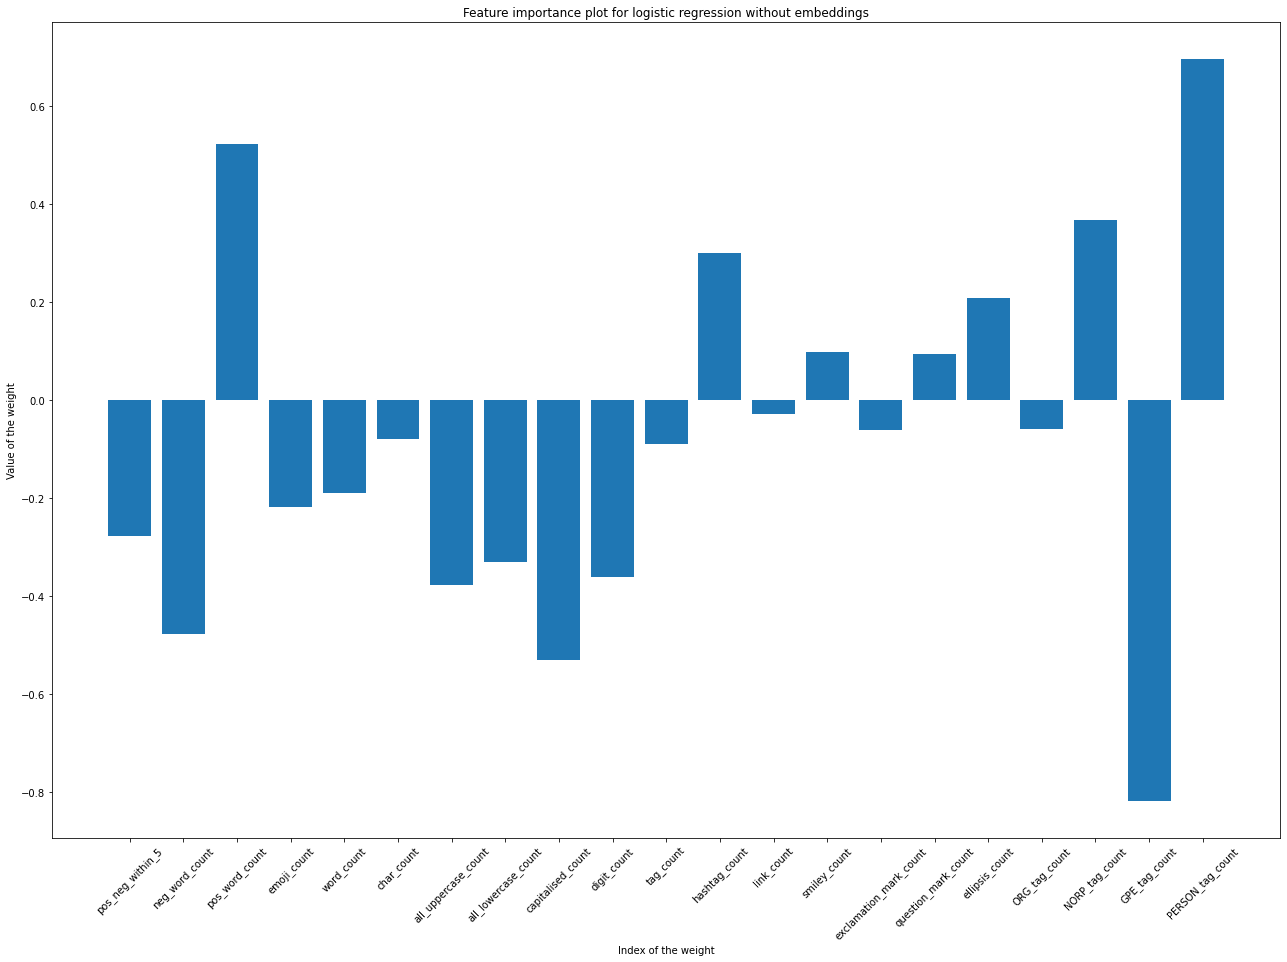

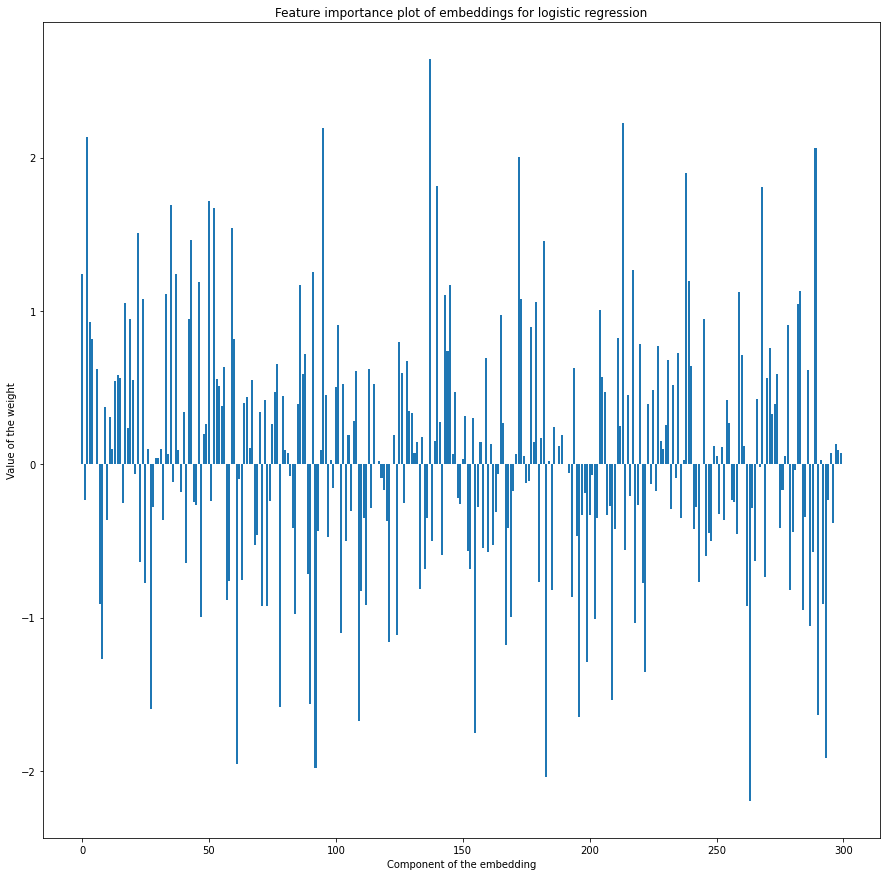

In [491]:
def plot_features_and_embeddings(pipeline, features=features_for_spec_topic):
    weights = pipeline['lr'].coef_.flatten()
    weights_wo_embeddings = weights[:-300].tolist()
    weights_embeddings = weights[-300:].tolist()

    plt.figure(figsize=(22, 15))
    plt.bar(features[:-300], weights_wo_embeddings)
    plt.ylabel('Value of the weight')
    plt.xlabel('Index of the weight')
    plt.xticks(rotation = 45) 
    plt.title('Feature importance plot for logistic regression without embeddings')
    plt.show()
    
    plt.figure(figsize=(15, 15))
    plt.bar(list(range(len(weights_embeddings))), weights_embeddings)
    plt.ylabel('Value of the weight')
    plt.xlabel('Component of the embedding')
    plt.title('Feature importance plot of embeddings for logistic regression')
    plt.show()
    
plot_features_and_embeddings(pipeline_lr_best)

## Best classifier for the 2nd topic

In [462]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.621     0.720     0.667       100
           1      0.582     0.470     0.520        83

    accuracy                          0.607       183
   macro avg      0.601     0.595     0.593       183
weighted avg      0.603     0.607     0.600       183
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.621     0.720     0.667       100
           1      0.582     0.470     0.520        83

    accuracy                          0.607       183
   macro avg      0.601     0.595     0.593       183
weighted avg      0.603     0.607     0.600       183
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.621     0.720     0.667       100
           1      0.582     0.470     0.520        8

In [463]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

KeyboardInterrupt: 

In [ ]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

In [ ]:
plot_features_and_embeddings(pipeline_lr_best)

## Best classifier for the 3rd topic

In [ ]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

In [ ]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

In [ ]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

In [ ]:
plot_features_and_embeddings(pipeline_lr_best)

## Best classifier for the 4th topic

In [ ]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

In [ ]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test, features_for_spec_topic)

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

params = {
    'lr__penalty': ['l1'],
    'lr__C': np.logspace(3, -9, 100),
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

In [ ]:
bp = search.best_params_
pipeline_lr_best = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(C=bp['lr__C'], penalty=bp['lr__penalty'], solver=bp['lr__solver']))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

In [ ]:
plot_features_and_embeddings(pipeline_lr_best)

## Permutation test to determine whether topic affects (global)